In [1]:
import random
import numpy as np
import gym
import matplotlib
import matplotlib.pyplot as plt
from importlib import reload

In [2]:
#!git clone https://github.com/santmarti/SDIC-Code.git
#%cd SDIC-Code/notebooks

In [3]:
from Environment import Environment, ACT_MODE, OBS_MODE
from Plotting import plotQ

-allo-gid-1ag Discrete Action Space with Discrete(4)


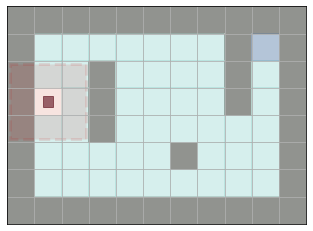

In [4]:
conf_walls = {"name": "FinalGrid",
        "rows": 8, "cols": 11,
        "max_steps": 500,
        "num_agents": 1,
        "action_mode": ACT_MODE.ALLOCENTRIC,
        "obs_mode": OBS_MODE.GLOBAL_ID,
        "walls": "dynaq",
        "floor": {"two_areas":1, "exit":"dynaq"},        # two areas is used for initializing the agent to the 0 area and 1 exit is added in 1 area
        "term_mode": "floor_exit"
        }

env = Environment(conf_walls)
env.reset()
env.render()
for a in [1,1,2,2,1,1]:
    env.step(a)


In [5]:
class Q_function():
    """ Same than before and         
        Adds discretization of continuous states to methods get and set
        Also adds counting of how many times a state has been visited/queried
        -> method visited
    """

    def __init__(self, env, params_qfunc={}):
        self.precision = 2 if "precision" not in params_qfunc else params_qfunc["precision"]
        self.ini_qvalue = 0 if "ini_qvalue" not in params_qfunc else params_qfunc["ini_qvalue"]
        self.nactions = env.action_space.n
        self.f = {}

    def tuple_discretize(self, s):
        if type(s) in [int, np.int64, np.int32]:
            return s
        elif type(s) in [np.float64]:
            return round(s, self.precision)
        if type(s) in [list, np.ndarray, tuple]:
            if len(s) == 1:
                return s[0]
            if len(s) == 0:
                return tuple(s)
            if len(s) == 2: # particular case of double input np.array and memory integer
                if type(s[0]) is np.ndarray and type(s[1]) is not np.ndarray:
                    s = np.array(list(s[0].flatten()) + [s[1]])
            if len(np.array(s).shape) > 1:
                s = np.array(s).flatten()
            if (type(s[0]) in [int, np.int64, np.int32]):
                return tuple(s)
            else:
                rs = [round(v, self.precision) for v in s]
                return tuple(rs)
        else:
            print("discretize of Q_func, Unrecognized type: " + str(type(s)))

    def predict(self, s, a=None):
        ts = self.tuple_discretize(s)
        if (ts not in self.f):
            self.f[ts] = [[self.ini_qvalue for _ in range(self.nactions)], 0]
        return self.f[ts][0] if a is None else self.f[ts][0][a]

    def update(self, s, a, y):
        ts = self.tuple_discretize(s)
        qs, nt = self.f[ts]
        qs[a] = y
        self.f[ts] = [qs, nt + 1]

    def visited(self, s, a=None):
        ts = self.tuple_discretize(s)
        return self.f[ts][1]

    def get(self, s, a=None):
        return self.predict(s, a)

    def set(self, s, a, y):
        self.update(s, a, y)

    def size(self):
        return len(self.f)

    def printQ(self):
        for key, value in sorted(self.f.items()):
            print(key, [round(v, 2) for v in value[0]], value[1])


    # for model storage instead of q_function
    def model_get(self, ts, a=None):
        if (ts not in self.f):
            self.f[ts] = [[0 for _ in range(self.nactions)], 0]
        return self.f[ts][0] if a is None else self.f[ts][0][a]

    def model_set(self, s, a, tsr):
        y = (self.tuple_discretize(tsr[0]), tsr[0], tsr[1])   # model store: convert to tuple, state, reward
        ts = self.tuple_discretize(s)
        self.model_get(ts)

        qs, nt = self.f[ts]
        qs[a] = y
        self.f[ts] = [qs, nt + 1]
        return ts

    def compare_equal(self, sa, sb):
        #return self.tuple_discretize(sa) == self.tuple_discretize(sb)
        return sa == sb

        
        

In [6]:
def print_info(n, i_episode, num_episodes, epsilon, sum_rew, Q=None, steps=None):
    if(i_episode == 0): 
        print(str(i_episode)," Starting learning running ",num_episodes," episodes plotting every ", int(n)," episodes")  
        return 
    if(epsilon < 0):
        print(i_episode,"   Mean Reward: ",sum_rew)
    else:
        str_steps = "" if steps is None else " Steps: "+str(steps)
        str_Q = "" if Q is None else " Q states: "+str(Q.size())
        print(i_episode, " epsilon: %.1f"%epsilon, "   Mean Reward: %.1f"%sum_rew, str_steps, str_Q)


In [7]:
class Policy_class():
    """ Class for the epsilon greedy policy
        Gets at initialization:
        -environment to store the number of actions in initialization 
        -The Q function
        
        Has method act: 
        -gets state and epsilon as input: acts randomly 
    """
    
    def __init__(self, env, Q, bActGreedy=True):       
        self.nactions = env.action_space.n
        self.Q = Q
        self.bActGreedy = bActGreedy

    def act_softmax(self,state,epsilon):
        q_values = np.array(self.Q.get(state))
        temp = 4*(epsilon+0.01)
        maxq = max(q_values/temp)
        exp = np.exp(q_values/temp - maxq)
        probs = exp/np.sum(exp)
        return np.random.choice(self.nactions, 1, p=probs)[0]  # from ... select 1 sample with probs   

    def act_prob_softmax(self, state, epsilon, a_real):
        q_values = np.array(self.Q.get(state))
        temp = 4*(epsilon+0.01)                    # 2 ... 100 temp range
        maxq = max(q_values/temp) 
        exp = np.exp(q_values/temp - maxq)
        probs = exp/np.sum(exp)
        return probs[a_real]

    def act_egreedy(self, state, epsilon=0):
        if np.random.rand() < epsilon:
            r_action = np.random.randint(self.nactions)
            return r_action
        else:
            q_values = self.Q.predict(state)
            return np.argmax(q_values)

    def act_prob_egreedy(self, state, epsilon, a_real):
        q_values = self.Q.predict(state)
        prob = np.log(epsilon/2.0)
        if(a_real == np.argmax(q_values)):
            prob += np.log(1-epsilon)
        return prob

    def act_prob(self, state, epsilon, a_real):
        if self.bActGreedy:
            return self.act_prob_egreedy(state, epsilon, a_real)
        else:
            return self.act_prob_softmax(state, epsilon, a_real)   # recent found bug

    def act(self, state, epsilon=0):
        if self.bActGreedy:
            return self.act_egreedy(state, epsilon)
        else:
            return self.act_softmax(state, epsilon)


In [14]:
def add_model_Q_updates(ts, pQueue, Q, M_bck, planning_steps=1, priority_th=0.0001, discount_factor=0.9):
    for a, tsr_tuple in enumerate(M_bck.model_get(ts)):
        if not isinstance(tsr_tuple, tuple): continue
        (ts_prev, s_prev, r) = tsr_tuple
        td_error = r + discount_factor * np.max(Q.model_get(ts)) - Q.model_get(ts_prev, a)
        if abs(td_error) > priority_th:
            if len(pQueue) > planning_steps:
                p = pQueue[-1][0]
                if abs(td_error) > p:
                    pQueue.append((abs(td_error), ts_prev, s_prev, a, 0))
                    pQueue.sort(key=lambda t: t[0], reverse=True)
                    pQueue.pop(-1)
            else:
                pQueue.append((abs(td_error), ts_prev, s_prev, a, 0))


def Dyna_Q(env, learning_rate=0.3, discount_factor=0.9, num_episodes=5000, num_episodes_end=4000, planning_steps=1, aQ_class=Q_function, debug=True):
    env.ini_observation_seed()
    env.history = {"episode_rew":[], "episode_steps":[]}

    Q = aQ_class(env)        # Q function
    M_fwd = aQ_class(env)    # transition model       M_fwd(s) -> [ (s',r) for a in nactions ]
    M_bck = aQ_class(env)    # reversed transition    M_bck(s') -> [ (s,r) for a in nactions ]

    policy = Policy_class(env, Q)
    pQueue = []

    sum_rew_epi, sum_steps  = 0, 0
    for i_episode in range(num_episodes):
        epsilon = max(1 - (1/num_episodes_end) * i_episode, 0.01)
        s_current = env.reset()
        sum_reward, steps = 0, 0
        done = False
        while not done:
            s = s_current
            a = policy.act(s, epsilon)
            s_new, reward, done, info = env.step(a)            
            s_current = s_new
            sum_reward += reward
            steps += 1
                
            td_error = reward + discount_factor * np.max(Q.get(s_new)) - Q.get(s, a)
            sum_rew_epi, sum_steps = sum_rew_epi + reward, sum_steps + 1

            M_bck.model_set(s_new, a, (s, reward))        # model backwards transition
            ts = M_fwd.model_set(s, a, (s_new, reward))   # model set fwd : returns tuple and qvalues

            if abs(td_error) > 0:  # really careful with this value, better 0
                pQueue.append( (abs(td_error), ts, s, a, 1) )        # we store in a dict: { priority : (state, action), ... }

            i = 0
            while i < planning_steps and len(pQueue) > 0:
                pQueue.sort(key=lambda t: t[0], reverse=True)
                p, ts, s, a, update_type = pQueue.pop(0)
                tsr_tuple = M_fwd.model_get(ts, a)             # model fwd get next state
                if not isinstance(tsr_tuple, tuple): continue
                ts_new, s_new, reward = tsr_tuple

                Qsa = Q.model_get(ts, a)
                max_value = np.max( Q.model_get(ts_new) )
                target = Qsa + learning_rate * (reward + discount_factor * max_value - Qsa)
                Q.set(s, a, target)   # Q update

                add_model_Q_updates(ts, pQueue, Q, M_bck, discount_factor=discount_factor, planning_steps=planning_steps)
                i += 1

        env.history["episode_rew"] += [sum_reward]
        env.history["episode_steps"] += [steps]

        n = num_episodes/20
        if (i_episode+1) % n == 0 and debug:
            print_info(n, i_episode, num_episodes, epsilon, sum_rew_epi/n, steps=sum_steps/n, Q=Q)
            sum_rew_epi, sum_steps = 0, 0

    return policy



> Seeding numpy, gym, tensorflow with seed  5  - RandomState stored
4  epsilon: 1.0    Mean Reward: -3.8  Steps: 378.8  Q states: 47
9  epsilon: 0.9    Mean Reward: -3.1  Steps: 309.0  Q states: 47
14  epsilon: 0.8    Mean Reward: -3.1  Steps: 306.2  Q states: 47
19  epsilon: 0.8    Mean Reward: -2.9  Steps: 287.4  Q states: 47
24  epsilon: 0.7    Mean Reward: -1.8  Steps: 176.2  Q states: 47
29  epsilon: 0.7    Mean Reward: -1.5  Steps: 154.0  Q states: 47
34  epsilon: 0.6    Mean Reward: -1.7  Steps: 171.6  Q states: 47
39  epsilon: 0.6    Mean Reward: -0.9  Steps: 88.0  Q states: 47
44  epsilon: 0.5    Mean Reward: -1.5  Steps: 146.2  Q states: 47
49  epsilon: 0.5    Mean Reward: -1.1  Steps: 112.8  Q states: 47
54  epsilon: 0.4    Mean Reward: -1.0  Steps: 98.0  Q states: 47
59  epsilon: 0.3    Mean Reward: -1.0  Steps: 96.6  Q states: 47
64  epsilon: 0.3    Mean Reward: -0.8  Steps: 75.4  Q states: 47
69  epsilon: 0.2    Mean Reward: -0.6  Steps: 56.2  Q states: 47
74  epsilon: 0.

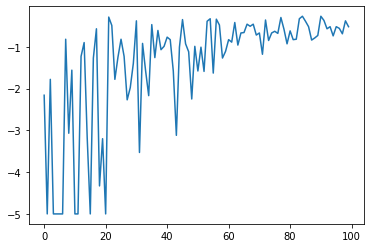

In [9]:
params = {"learning_rate":0.1, "discount_factor":0.8, "num_episodes":100, "num_episodes_end":90, "planning_steps":50}
policy = Dyna_Q(env, **params)
q_func_dyna = policy.Q

plt.plot(env.history["episode_rew"])

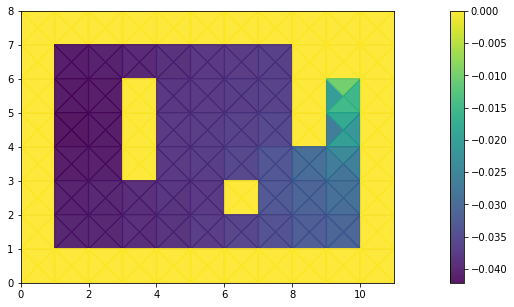

In [10]:
plotQ(env, q_func_dyna)

> Seeding numpy, gym, tensorflow with seed  65  - RandomState stored
1 Planning steps,     Mean reward: -0.3930000000000001
> Seeding numpy, gym, tensorflow with seed  67  - RandomState stored
10 Planning steps,     Mean reward: -0.3000000000000001
> Seeding numpy, gym, tensorflow with seed  39  - RandomState stored
100 Planning steps,     Mean reward: -0.2695


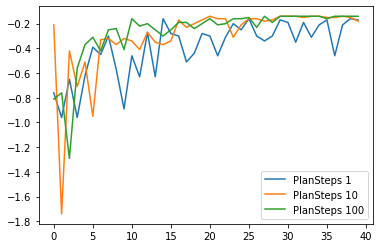

In [18]:
# DynaQ comparison
params = {"learning_rate":0.1, "discount_factor":0.8, "num_episodes":50, "num_episodes_end":40, "debug":False}

for planning_steps in [1,10,100]:
    params["planning_steps"] = planning_steps
    policy = Dyna_Q(env, **params)
    q_func_dyna = policy.Q
    rew = np.array(env.history["episode_rew"])
    rew = rew[10:]
    plt.plot(rew, label='PlanSteps %d'%planning_steps)
    plt.legend()
    print(planning_steps,"Planning steps,     Mean reward:",np.mean(rew))


In [12]:
env.ini_observation_seed()

> Seeding numpy, gym, tensorflow with seed  61  - RandomState stored
